# Data Preparation

## Import Packages and Data

In [2]:
# Standard
import pandas as pd
import numpy as np
import random
import os
import math

# TF and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras import metrics
from keras import losses
from keras import regularizers
from tqdm.keras import TqdmCallback 

# Plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

# Silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Setting random seeds
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

2023-12-10 22:11:57.184438: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
# Reading in the CSVs
X_train = pd.read_csv('data/X_train.csv')
Y_train = pd.read_csv('data/Y_train.csv')
X_val = pd.read_csv('data/X_val.csv')
Y_val = pd.read_csv('data/Y_val.csv')
X_test = pd.read_csv('data/X_test.csv')
Y_test = pd.read_csv('data/Y_test.csv')

In [20]:
# Drop unecessary columns added to the beginning of each DF
for df in [X_train, Y_train, X_val, Y_val, X_test, Y_test]:
    df.drop(columns=['Unnamed: 0', 'name_normalized'], inplace=True)

## Making One-Hot Encodings and Tensors for Categorical Variables

In [21]:
# Merging train, val, and test sets into one DF to perform the encodings in one batch
X = pd.concat([X_train, X_val, X_test])

# Making the numerical categorical variables into strings - necessary to make the one-hot encodings
X[['opp_diff_ind', 'GW','was_home']] = X[['opp_diff_ind', 'GW','was_home']].astype(str)

In [22]:
# Making categorical variables into sparse one-hot encodings
season_tf = tf.keras.layers.StringLookup(vocabulary=X.season.unique(), output_mode='one_hot')(X.season)

player_team_name_tf = tf.keras.layers.StringLookup(vocabulary=X.player_team_name.unique(), 
                                                         output_mode='one_hot')(X.player_team_name)

opp_team_name_tf = tf.keras.layers.StringLookup(vocabulary=X.opp_team_name.unique(), 
                                                      output_mode='one_hot')(X.opp_team_name)

opp_diff_ind_tf = tf.keras.layers.StringLookup(vocabulary=X.opp_diff_ind.unique(), 
                                                      output_mode='one_hot')(X.opp_diff_ind)

position_tf = tf.keras.layers.StringLookup(vocabulary=X.position.unique(), output_mode='one_hot')(X.position)

gw_tf = tf.keras.layers.StringLookup(vocabulary=X.GW.unique(), output_mode='one_hot')(X.GW)

was_home_tf = tf.keras.layers.StringLookup(vocabulary=X.was_home.unique(), output_mode='one_hot')(X.was_home)

In [23]:
# Getting the correct split sizes to split the tensors into train, val, and test again
split_one = X_train.shape[0]
split_two = X_val.shape[0]
split_three = X_test.shape[0]

# Splitting the encoded tensors into train, val, and test tensors
season_train, season_val, season_test = tf.split(season_tf, [split_one, split_two, split_three], 0)

player_team_name_train, player_team_name_val, player_team_name_test = tf.split(player_team_name_tf, [split_one, split_two, split_three], 0)

opp_team_name_train, opp_team_name_val, opp_team_name_test = tf.split(opp_team_name_tf, [split_one, split_two, split_three], 0)

opp_diff_ind_train, opp_diff_ind_val, opp_diff_ind_test = tf.split(opp_diff_ind_tf, [split_one, split_two, split_three], 0)

position_train, position_val, position_test = tf.split(position_tf, [split_one, split_two, split_three], 0)

gw_train, gw_val, gw_test = tf.split(gw_tf, [split_one, split_two, split_three], 0)

was_home_train, was_home_val, was_home_test = tf.split(was_home_tf, [split_one, split_two, split_three], 0)

## Turning Continuous Variables into Tensors

In [24]:
# Grabbing only the continuous columns we want
# Note: hyperparameter tuning found that lag_3 was the optimal choice between 1, 3, and 5, so we use it here
cols = ['assists_lag_5', 'bonus_lag_5', 'bps_lag_5', 'clean_sheets_lag_5',
        'creativity_lag_5', 'goals_conceded_lag_5', 'goals_scored_lag_5',
        'ict_index_lag_5', 'influence_lag_5', 'minutes_lag_5',
        'own_goals_lag_5', 'penalties_missed_lag_5', 'penalties_saved_lag_5',
        'red_cards_lag_5', 'saves_lag_5', 'selected_lag_5',
        'player_team_score_lag_5', 'opp_team_score_lag_5', 'threat_lag_5',
        'total_points_lag_5', 'value_lag_5', 'yellow_cards_lag_5']

In [25]:
# Making continuous variable tensors
# Naming convention: "contin" stands for "continuous" and tf signifies that these are tensors
X_train_contin_tf = tf.convert_to_tensor(X_train[cols])
X_val_contin_tf = tf.convert_to_tensor(X_val[cols])
X_test_contin_tf = tf.convert_to_tensor(X_test[cols])

## Making Final X and Y input Tensors

In [26]:
# Making lists of train, val, and test tensors to combine
# Note: using this method (rather than pytorch) because pytorch kept crashing my kernel
X_train_tensor_list = [season_train, player_team_name_train, opp_team_name_train, opp_diff_ind_train, 
                       position_train, gw_train, was_home_train, X_train_contin_tf]

X_val_tensor_list = [season_val, player_team_name_val, opp_team_name_val, opp_diff_ind_val, 
                     position_val, gw_val, was_home_val, X_val_contin_tf]

X_test_tensor_list = [season_test, player_team_name_test, opp_team_name_test, opp_diff_ind_test, 
                      position_test, gw_test, was_home_test, X_test_contin_tf]

In [27]:
# Concatenating input tensors
X_train_tf = tf.keras.layers.Concatenate(axis=1)(X_train_tensor_list)
X_val_tf = tf.keras.layers.Concatenate(axis=1)(X_val_tensor_list)
X_test_tf = tf.keras.layers.Concatenate(axis=1)(X_test_tensor_list)

In [28]:
# Making target tensors
Y_train_tf = tf.convert_to_tensor(Y_train)
Y_val_tf = tf.convert_to_tensor(Y_val)
Y_test_tf = tf.convert_to_tensor(Y_test)

## Defining Plotting Function

In [29]:
def mse_mae_plots(history):
    '''
    Takes in history from model fitting and plots loss and MAE by epoch for both train and val
    '''
    hist = history.history
    x_arr = np.arange(len(hist['loss'])) + 1
    
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', color='darkturquoise', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '-s', color='mediumvioletred', label='Validation loss')
    plt.axhline(y = MSE(true, pred), color = 'limegreen', linestyle = '-') # Adding a horizontal line for baseline MSE
    ax.legend(fontsize=12)
    ax.set_xlabel('Epoch', size=12)
    ax.set_ylabel('Mean Squared Error (MSE)', size=12)
    ax.set_title('MSE by Epoch')

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['mean_absolute_error'], '-o', color='darkturquoise', label='Train MAE')
    ax.plot(x_arr, hist['val_mean_absolute_error'], '-s', color='mediumvioletred', label='Validation MAE')
    plt.axhline(y = MAE(true, pred), color = 'limegreen', linestyle = '-') # Adding a horizontal line for baseline MAE
    ax.legend(fontsize=12)
    ax.set_xlabel('Epoch', size=12)
    ax.set_ylabel('Mean Absolute Error (MAE)', size=12)
    ax.set_title('MAE by Epoch')

# Making a Baseline

In [30]:
# Setting up necessary functions

# Making a vector of predictions as long as the actuals
def pred_vect(true_values, prediction=2):
    predictions = []
    count = 0
    pred = prediction # Can pass baseline or 2
    while count < len(true_values):
        predictions.append(pred)
        count += 1
        
    return predictions

# Defining loss functions
def MSE(true_values, predicted_values):
    """Return the MSE between true_values and predicted values."""
    tot = 0
    count = 0
    
    # Calculating the SE for each data point
    while count < len(true_values):
        tot += (true_values[count] - predicted_values[count])**2
        count += 1
    
    # Returning the MSE
    return tot / len(true_values)

def RMSE(true_values, predicted_values):
    """Return the RMSE between true_values and predicted values."""
    tot = 0
    count = 0
    
    # Calculating the SE for each data point
    while count < len(true_values):
        tot += (true_values[count] - predicted_values[count])**2
        count += 1
    
    # Returning the RMSE
    return math.sqrt(tot / len(true_values))

def MAE(true_values, predicted_values):
    """Return the MAE between true_values and predicted values."""
    tot = 0
    count = 0
    
    # Calculating the SE for each data point
    while count < len(true_values):
        tot += abs(true_values[count] - predicted_values[count])
        count += 1
    
    # Returning the MAE
    return tot / len(true_values)

In [31]:
# Creating a baseline with the average value
baseline = Y_train['total_points'].mean()

In [32]:
true = np.array(Y_test['total_points'])
pred = np.array(pred_vect(Y_test['total_points'],baseline))

print(f'MSE is {round(MSE(true, pred),3)}')
print(f'RMSE is {round(RMSE(true, pred),3)}')
print(f'MAE is {round(MAE(true, pred),3)}')

MSE is 5.573
RMSE is 2.361
MAE is 1.595


# Making a linear regression model

In [33]:
# Defining a function to create linear regression models
def make_lin_reg_model(epoch_count=20, learning_rate=0.0005, optimizer='Adam', decay_steps=10000, decay_rate=0.95, lr_sched='yes'):

    ############################################################################################## 1
    # Preparing the data
    num_features = X_train_tf.shape[1]

    ############################################################################################## 2
    # Building the model
    tf.keras.backend.clear_session()
    model = tf.keras.Sequential()
    
    # Create input layer
    model.add(tf.keras.Input(shape=(num_features,), name='Input'
              ))
    
    # Create output layer
    model.add(tf.keras.layers.Dense(
              activation = None,    # linear activation
              units = 1,            
              use_bias = True             
              ))
    
    # Set a learning rate schedule
    if lr_sched == 'yes':
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=decay_steps,
            decay_rate=decay_rate)
    else:
        lr_schedule = learning_rate
    
    # Set optimizer
    if optimizer == 'SGD':
      opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
    elif optimizer == 'Adam':
      opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    else:
      raise 'Unsupported optimizer: %s' %optimizer

    ############################################################################################## 3
    # Compiling the model
    model.compile(
        optimizer=opt,
        loss=losses.MeanSquaredError(),
        metrics=[metrics.mse,
                 metrics.RootMeanSquaredError(),
                 metrics.mae]
        )

    ############################################################################################## 4
    # Fitting the model
    history = model.fit(
        x = X_train_tf,
        y = Y_train_tf,
        epochs = epoch_count,
        validation_data = (X_val_tf, Y_val_tf),
        verbose=False,
        callbacks=[TqdmCallback()]
        )

    ############################################################################################## 5
    # Plotting the results
    mse_mae_plots(history)

    ############################################################################################## 6
    # Evaluating the model
    
    results = model.evaluate(X_test_tf, Y_test_tf)
    print(f'MSE is {round(results[1],3)}')
    print(f'RMSE is {round(results[2],3)}')
    print(f'MAE is {round(results[3],3)}')

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

829/829 [==============================] - 0s 492us/step - loss: 4.1350 - mean_squared_error: 4.1350 - root_mean_squared_error: 2.0335 - mean_absolute_error: 1.0890
MSE is 4.135
RMSE is 2.033
MAE is 1.089


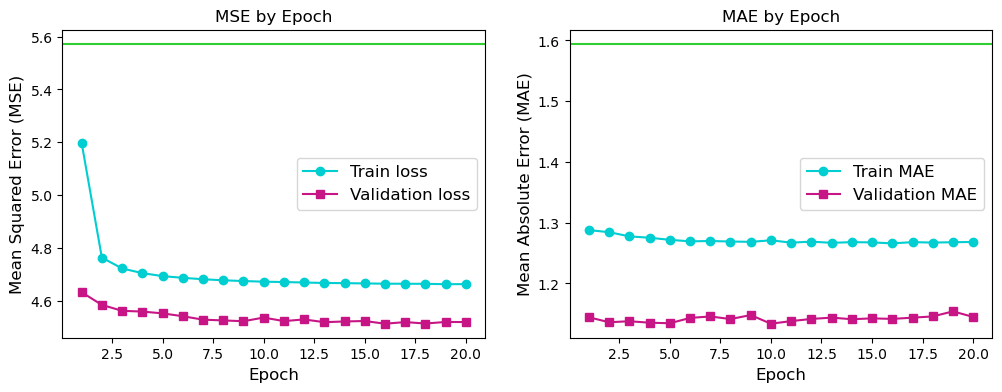

In [34]:
make_lin_reg_model(learning_rate=0.0005, optimizer='Adam', epoch_count=20, lr_sched='yes', decay_steps=10000, decay_rate=0.9)

# Making a FFNN

In [35]:
# Setup for testing different configurations

def create_nn(learning_rate=0.00001, epoch_count=175, hidden_layer_sizes=[150, 75], 
              hl_act_func='relu', dropout_rate=0.1, oput_act_func='relu', optimizer='Adam', plot_flag=True,
              verbosity_flag=False, lr_sched='yes', decay_steps=10000, decay_rate=0.95):
    
    ############################################################################################## 1
    # Getting number of features
    num_features = X_train_tf.shape[1]

    ############################################################################################## 2
    # Building the model
    tf.keras.backend.clear_session()
    model = tf.keras.Sequential()

    # Create input layer
    model.add(tf.keras.Input(shape=(num_features,), name='Input'
              ))

    # Create hidden layers
    for i, hidden_layer_size in enumerate(hidden_layer_sizes):
      model.add(tf.keras.layers.Dense(units=hidden_layer_size,
                                     activation=hl_act_func,
                                     name = f'Hidden_{i+1}'))
    
      # Create dropout after each hidden layer
      model.add(tf.keras.layers.Dropout(rate=dropout_rate, name=f'Dropout_{i+1}') # Need to make dropout rate variable
              )
    
    
    # Create output layer
    model.add(tf.keras.layers.Dense(
              activation = oput_act_func, 
              units = 1,                
              use_bias = True
              ))

    # Set a learning rate schedule
    if lr_sched == 'yes':
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=decay_steps,
            decay_rate=decay_rate)
    else:
        lr_schedule = learning_rate
    
    # Set optimizer
    if optimizer == 'SGD':
      opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
    elif optimizer == 'Adam':
      opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    else:
      raise 'Unsupported optimizer: %s' %optimizer

    ############################################################################################## 3
    # Compiling the model
    model.compile(
        optimizer=opt,
        loss='mse',
        metrics=[metrics.mse,
                 metrics.RootMeanSquaredError(),
                 metrics.mae]
        )

    ############################################################################################## 4
    # Fitting the model
    history = model.fit(
        x = X_train_tf,
        y = Y_train_tf,
        epochs = epoch_count,
        validation_data = (X_val_tf, Y_val_tf),
        verbose=verbosity_flag,
        callbacks=[TqdmCallback()]
    )

    ############################################################################################## 5
    # Displaying learning rates
    if plot_flag == True:
        mse_mae_plots(history)

    return model

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

829/829 [==============================] - 1s 594us/step - loss: 3.9839 - mean_squared_error: 3.9839 - root_mean_squared_error: 1.9960 - mean_absolute_error: 1.0453
MSE is 3.984
RMSE is 1.996
MAE is 1.045


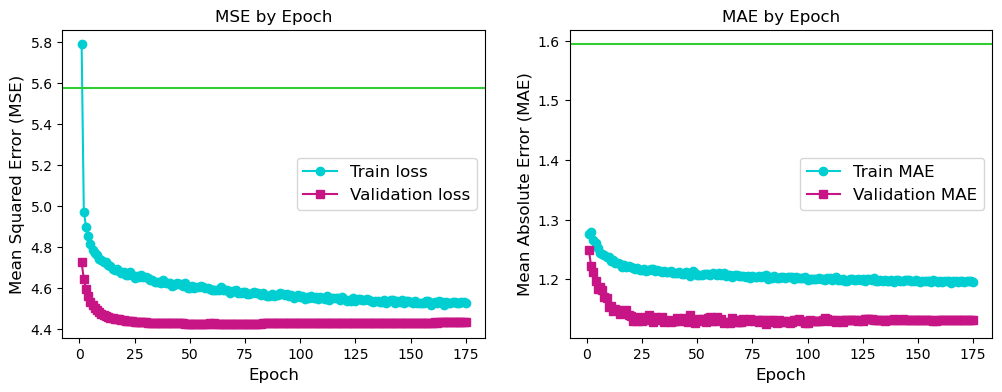

In [36]:
# Creating the model
final_model = create_nn(epoch_count=175)
ffnn_results = final_model.evaluate(X_test_tf, Y_test_tf)
print(f'MSE is {round(ffnn_results[1],3)}')
print(f'RMSE is {round(ffnn_results[2],3)}')
print(f'MAE is {round(ffnn_results[3],3)}')